In [1]:
import numpy as np
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn import preprocessing
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
basic_property_keys = ['num_characters','num_edges_unweighted','weighted_degree_sum', \
                       'weighted_degree_max','weighted_degree_avg','clustering_coefficients',\
                       'density', 'max_shortest_path','avg_shortest_path','num_connected_components',\
                       'connected_component_max_size','connected_component_avg_size',\
                       'num_in_1core','num_in_2core','num_in_3core','num_in_4core',\
                       'num_in_5core','GN_Modularity','CNM_Modularity']
motif = ['3_motif_1', '3_motif2', '4_motif_1', '4_motif2', '4_motif_3', '4_motif4', '4_motif_5', '4_motif6']
central_node_egonet_keys = ['node_0_0', 'node_0_1', 'node_0_2', 'node_0_3', 'node_0_4', 'node_0_5', \
                 'node_0_6', 'node_0_7', 'node_0_8', 'node_0_9', 'node_0_10', 'node_0_11', \
                 'node_0_12', 'node_0_13', 'node_0_14', 'node_0_15', 'node_0_16', 'node_0_17',\
                 'node_0_18', 'node_0_19', 'node_0_20', 'node_0_21', 'node_0_22', 'node_0_23',\
                 'node_0_24', 'node_0_25', 'node_0_26']
# deg_second_egonet = ['node_1_0', 'node_1_1', 'node_1_2',\
#                  'node_1_3', 'node_1_4', 'node_1_5', 'node_1_6', 'node_1_7', 'node_1_8',\
#                  'node_1_9', 'node_1_10', 'node_1_11', 'node_1_12', 'node_1_13', 'node_1_14',\
#                  'node_1_15', 'node_1_16', 'node_1_17', 'node_1_18', 'node_1_19', 'node_1_20',\
#                  'node_1_21', 'node_1_22', 'node_1_23', 'node_1_24', 'node_1_25', 'node_1_26']
anonymous_walk_keys = ['embed_{}'.format(i) for i in range(128)]
anonymous_walk_prob_keys = ['embed_awefb_{}'.format(i) for i in range(128)]
graph_sum_embedding_keys = ['sum_0', 'sum_1', 'sum_2', 'sum_3', 'sum_4', 'sum_5', 'sum_6', 'sum_7', \
                 'sum_8', 'sum_9', 'sum_10', 'sum_11', 'sum_12', 'sum_13', 'sum_14', 'sum_15',\
                 'sum_16', 'sum_17', 'sum_18', 'sum_19', 'sum_20', 'sum_21', 'sum_22',\
                 'sum_23','sum_24', 'sum_25', 'sum_26', 'sum_27', 'sum_28', 'sum_29', \
                 'sum_30', 'sum_31']
graph_avg_embedding_keys = ['avg_0','avg_1','avg_2','avg_3','avg_4','avg_5','avg_6',\
                 'avg_7','avg_8','avg_9','avg_10','avg_11','avg_12','avg_13','avg_14',\
                 'avg_15','avg_16','avg_17','avg_18','avg_19','avg_20','avg_21','avg_22',\
                 'avg_23','avg_24','avg_25','avg_26','avg_27','avg_28','avg_29','avg_30',\
                 'avg_31']
imdb_property_keys = ['ratingCount', 'Adult','duration', 'year', 'nrOfWins', \
                      'nrOfNominations', 'nrOfPhotos', 'nrOfNewsArticles', 'nrOfUserReviews']
# genre_keys = ['Action','Adventure','Animation','Biography','Comedy','Crime',\
#               'Drama','Family','Fantasy','FilmNoir','History','Horror','Music',\
#               'Musical','Mystery','Romance','SciFi','Sport','Thriller','War','Western']
genre_keys = ['Action','Adventure','Biography','Comedy','Crime','Drama','Fantasy','Horror',
              'Mystery','Romance','SciFi','Thriller']
rating_key = ['imdbRating']
all_keys = [basic_property_keys, central_node_egonet_keys, anonymous_walk_keys, \
            graph_sum_embedding_keys, graph_avg_embedding_keys, imdb_property_keys, anonymous_walk_prob_keys, motif]

# Read Dataset and split test & training data

In [3]:
dataset = pd.read_csv('datasets/clean/dataset.csv', escapechar='\\')

In [4]:
# Decide the training tasks here
y_columns=rating_key
x_columns=basic_property_keys+central_node_egonet_keys+anonymous_walk_keys\
+graph_sum_embedding_keys+graph_avg_embedding_keys+imdb_property_keys
# x_columns=central_node_egonet_keys

In [5]:
y = dataset[y_columns].values[:,0]
x = dataset[x_columns].values
y.shape, x.shape

((659,), (659, 247))

# Split test & training data

In [6]:
# test_number = 119
n_fold = 11 # For cross-validation
samples_per_fold = 60 # For cross-validation
# y_test = y[:test_number]
# y_train = y[test_number:]
# x_test = x[:test_number]
# x_train = x[test_number:]
y_train = y
# x_train = x

In [7]:
mse = lambda prediction, y_test:np.mean(np.square(prediction - y_test))

# Lasso regression

In [271]:
# Cross validation:
alphas = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2]
mse_cross_validation_accuracy = np.zeros((len(alphas), len(all_keys)))
for k in range(len(alphas)):
    alpha = alphas[k]
    for j in range(len(all_keys)):
        feature_key = all_keys[j]
        accurs = []
        y_predicts = []
        y_tests = []
        y_train = dataset[y_columns].values
        x_train = dataset[feature_key].values
        scaling = preprocessing.MinMaxScaler(feature_range=(-1,1)).fit(x_train)
        svr_x_train = scaling.transform(x_train)
        for i in range(n_fold):
            if i == 10:
                test_index = list(range(i*samples_per_fold, (i+1)*samples_per_fold-1))
            else:
                test_index = list(range(i*samples_per_fold, (i+1)*samples_per_fold))
            train_index = list(range(i*samples_per_fold)) + list(range((i+1)*samples_per_fold, n_fold*samples_per_fold-1))
            this_x_test = x_train[test_index]
            this_y_test = y_train[test_index]
            lasso_clf = linear_model.Lasso(alpha=alpha)
            lasso_clf.fit(x_train[train_index], y_train[train_index])
            this_pred = lasso_clf.predict(x_train[test_index])
            accurs.append(mse(this_pred, y_train[test_index]))
        mse_cross_validation_accuracy[k, j] = np.mean(accurs)

/Users/zhenqin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/zhenqin/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [276]:
selelct_features =['year', 'nrOfWins', 'nrOfNominations','num_in_2core',\
                   'node_0_0', 'node_0_11', 'node_0_12',  'node_0_3',\
                  'CNM_Modularity', 'GN_Modularity','max_shortest_path', 'embed_108', 'embed_41', \
                   'embed_26', 'embed_1']
feature_key = selelct_features
accurs_lasso = []
accurs_svr = []
lasso_coeffs = np.zeros((n_fold, len(selelct_features)))
svr_coeffs = np.zeros((n_fold, len(selelct_features)))
y_tests = []
y_train = dataset[y_columns].values
x_train = dataset[feature_key].values
scaling = preprocessing.MinMaxScaler(feature_range=(-1,1)).fit(x_train)
svr_x_train = scaling.transform(x_train)
for i in range(n_fold):
    if i == 10:
        test_index = list(range(i*samples_per_fold, (i+1)*samples_per_fold-1))
    else:
        test_index = list(range(i*samples_per_fold, (i+1)*samples_per_fold))
    train_index = list(range(i*samples_per_fold)) + list(range((i+1)*samples_per_fold, n_fold*samples_per_fold-1))
    this_x_test = svr_x_train[test_index]
    this_y_test = y_train[test_index]
    # Lasso
    lasso_clf = linear_model.Lasso(alpha=0.02)
    lasso_clf.fit(svr_x_train[train_index], y_train[train_index])
    this_pred = lasso_clf.predict(svr_x_train[test_index])
    accurs_lasso.append(mse(this_pred, y_train[test_index]))
    lasso_coeffs[i] = lasso_clf.coef_
    # SVR
    svr = SVR(kernel='linear', C=0.007, epsilon = 0.005)
    svr.fit(svr_x_train[train_index], y_train[train_index])
    this_pred = svr.predict(svr_x_train[test_index])
    accurs_svr.append(mse(this_pred, y_train[test_index]))
    svr_coeffs[i] = svr.coef_[0]
np.mean(accurs_lasso), np.mean(accurs_svr)

/Users/zhenqin/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(0.8640806810970486, 0.8212124857898835)

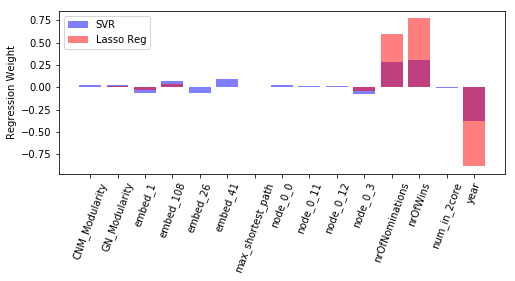

In [277]:
plt.figure(figsize=(8,3))
plt.bar(feature_key, np.mean(svr_coeffs, axis=0), alpha = 0.5, label='SVR', color='blue')
plt.bar(feature_key, np.mean(lasso_coeffs, axis=0), alpha = 0.5, label='Lasso Reg', color='red')
plt.legend(loc='best')
plt.tick_params(axis='x', rotation=70, )
plt.ylabel("Regression Weight")
plt.show()

In [29]:
np.mean(accurs)

0.9438401585950622

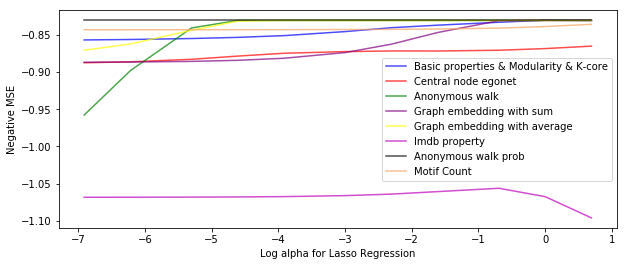

In [272]:
log_alphas = np.log(np.array(alphas))
plt.figure(figsize=(10,4))
plt.plot(log_alphas, -mse_cross_validation_accuracy[:,0],color='blue', label='Basic properties & Modularity & K-core', alpha= 0.7)
plt.plot(log_alphas, -mse_cross_validation_accuracy[:,1],color='red', label='Central node egonet', alpha= 0.7)
plt.plot(log_alphas, -mse_cross_validation_accuracy[:,2],color='green', label='Anonymous walk', alpha= 0.7)
plt.plot(log_alphas, -mse_cross_validation_accuracy[:,3],color='purple', label = 'Graph embedding with sum', alpha= 0.7)
plt.plot(log_alphas, -mse_cross_validation_accuracy[:,4],color='yellow', label ='Graph embedding with average', alpha= 0.7)
plt.plot(log_alphas, -mse_cross_validation_accuracy[:,5],color='m', label = 'Imdb property', alpha= 0.7)
plt.plot(log_alphas, -mse_cross_validation_accuracy[:,6],color='black', label = 'Anonymous walk prob', alpha= 0.7)
plt.plot(log_alphas, -mse_cross_validation_accuracy[:,7],color='sandybrown', label = 'Motif Count', alpha= 0.7)
plt.legend()
plt.xlabel("Log alpha for Lasso Regression")
plt.ylabel("Negative MSE")
plt.show()

In [38]:
mse_cross_validation_accuracy[:,7]

array([0.84299159, 0.84298624, 0.84297021, 0.84294352, 0.84289032,
       0.84273207, 0.84247278, 0.84198041, 0.84084974, 0.8386885 ,
       0.83569437])

# SVR on Graph properties

In [273]:
# Cross validation:
Cs = [0.001, 0.005, 0.01, 0.05, 0.1]
mse_cross_validation_accuracy = np.zeros((len(Cs), len(all_keys)))
for k in range(len(Cs)):
    c = Cs[k]
    for j in range(len(all_keys)):
        feature_key = all_keys[j]
        accurs = []
        y_predicts = []
        y_tests = []
        y_train = dataset[y_columns].values
        x_train = dataset[feature_key].values
        scaling = preprocessing.MinMaxScaler(feature_range=(-1,1)).fit(x_train)
        svr_x_train = scaling.transform(x_train)
        for i in range(n_fold):
            if i == 10:
                test_index = list(range(i*samples_per_fold, (i+1)*samples_per_fold-1))
            else:
                test_index = list(range(i*samples_per_fold, (i+1)*samples_per_fold))
            train_index = list(range(i*samples_per_fold)) + list(range((i+1)*samples_per_fold, n_fold*samples_per_fold-1))
            this_x_test = x_train[test_index]
            this_y_test = y_train[test_index]
            svr = SVR(kernel='linear', C=c, epsilon = 0.1)
            svr.fit(svr_x_train[train_index], y_train[train_index])
            this_pred = svr.predict(svr_x_train[test_index])
            accurs.append(mse(this_pred, y_train[test_index]))
        mse_cross_validation_accuracy[k, j] = np.mean(accurs)

/Users/zhenqin/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/zhenqin/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [67]:
mse_cross_validation_accuracy[:,2]

array([0.83363225, 0.85955025, 0.89219057, 1.01337385, 1.06087339])

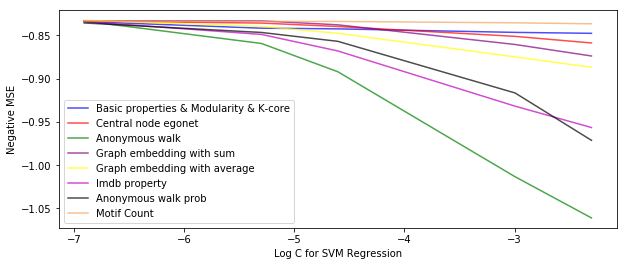

In [275]:
log_cs = np.log(np.array(Cs))
plt.figure(figsize=(10,4))
plt.plot(log_cs, -mse_cross_validation_accuracy[:,0],color='blue', label='Basic properties & Modularity & K-core', alpha= 0.7)
plt.plot(log_cs, -mse_cross_validation_accuracy[:,1],color='red', label='Central node egonet', alpha= 0.7)
plt.plot(log_cs, -mse_cross_validation_accuracy[:,2],color='green', label='Anonymous walk', alpha= 0.7)
plt.plot(log_cs, -mse_cross_validation_accuracy[:,3],color='purple', label = 'Graph embedding with sum', alpha= 0.7)
plt.plot(log_cs, -mse_cross_validation_accuracy[:,4],color='yellow', label ='Graph embedding with average', alpha= 0.7)
plt.plot(log_cs, -mse_cross_validation_accuracy[:,5],color='m', label = 'Imdb property', alpha= 0.7)
plt.plot(log_cs, -mse_cross_validation_accuracy[:,6],color='black', label = 'Anonymous walk prob', alpha= 0.7)
plt.plot(log_cs, -mse_cross_validation_accuracy[:,7],color='sandybrown', label = 'Motif Count', alpha= 0.7)
plt.legend()
plt.xlabel("Log C for SVM Regression")
plt.ylabel("Negative MSE")
plt.show()

In [77]:
mse_cross_validation_accuracy[:,7]

array([0.83359643, 0.83407805, 0.83412652, 0.83573529, 0.83684512])